# Golden redfish in Icelandic waters: a statistical approach

This Jupyter notebook contains the python code for the Golden redfish model that Maris Optimum has developed.

    Sources:
    1.Data from Icelandic Marine and freshwater institute 
    2.It uses the gradient boosting regression algorithm xgboost and various packages
    3.It is written in the python programming language
    
    The main pacckages used are:
    1.the xgboost regressor (https://xgboost.readthedocs.io/en/stable/index.html) 
    2.the scikit-learn suite (https://scikit-learn.org/stable/user_guide.html)
    3.the shap suite (https://shap.readthedocs.io/en/latest/index.html) 
    


### Packages imported

In [1]:
"""Optimal regression found to estimate cathc sizes."""
import pandas as pd
import math
# import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
# from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
# from sklearn.pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
import xgboost as xgb
# from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import RandomizedSearchCV
import shap
import time

path_str = 'R:\\Ráðgjöf\\Maris Optimum/gr_data\\'
# path_str = ''

### Conversion of kg catch to units of fish

The annual catch of the fleet is reported by weight. The statistical model is based on number of fish at each length cm. This conversion algorithm was developed to use data from the IMFI surveys to convert the catch into lengths and number of fish. To convert the IMFI annual data from kg to lengths polynomial regression of the second order was employed.

In [2]:
def catch_converter(X_catch_per_df, catch_df):
    """
    Catch information used to formulate units from kg.

    Parameters
    ----------
    X_catch_per_df : Dataframe containing percentages of catch
    catch_df : Dataframe containing total cath in kg

    Returns
    -------
    catch_df : Dataframe containing total catch in lengths
    """
    path_grs_str = 'R:/Ráðgjöf/Maris Optimum/Golden_redfish_model/'
    # path_grs_str = ''
    wl_df = pd.read_csv(path_grs_str+'RED_gadget_n_at_age.csv', sep=',')

    Xl = wl_df[['year', 'mean_length']].copy()
    yl = wl_df[['year', 'mean_weight']].copy()

    for index, row in Xl.iterrows():
        Xl.at[index, 'squared'] = row[1]**2

    for year in range(1985, 2022):
        average_weight = 0
        reg_X = Xl[Xl['year'] == year]
        reg_y = yl[yl['year'] == year]
        reg = LinearRegression().fit(
            reg_X[['mean_length', 'squared']], reg_y[['mean_weight']])
        b = reg.coef_[0][0]
        a = reg.coef_[0][1]
        c = reg.intercept_
        for col in range(1010, 1060):
            average_weight += (X_catch_per_df.loc[year, str(col)]) * (
                a*(col - 1000)**2 + b*(col - 1000) + c)
        catch_df.at[
            year - 1985, 'number'] = catch_df.loc[
                year - 1985, 'catch']/average_weight
    return catch_df


### Data fetched

Data is from Iceland Marine and freshwater institute spring surveys and catch reports. Survey data has been modied in one aspect as the comopositon of large schools may have undue influence on the overall samples. The impact of largest schools has therefore been reduced to the size of the 96th fractile of school sizes. See appendix 1 for more detail.
the independant data contains 108 variables. The first 51 are taken directly from every spring survey from 1985 and contains the percent of individuals in each length group. Next there is a variable, max(cum) which contains the number of fish caught in the survey. The final 51 variables contain the number of individuals caught in each length group by the fishing fleet.

In [3]:
def get_new_data(fractile):
    """
    Fetch all data for the regression.

    Parameters
    ----------
    fractile : integer

    Returns
    -------
    XX_df : Dataframe with data for all dependent variables
    YY : Dataframe with data for the independant variable

    """
    X100_df = pd.read_csv(path_str + 'distribution100.csv',
                          sep=",")
    ysq_df = X100_df[['ar', 'max(cum)']].copy()
    ysq_df.set_index(['ar'], inplace=True)
    ysq_df = ysq_df[~ysq_df.index.duplicated(keep='first')]

    X_df = pd.read_csv(path_str + 'distribution' + fractile + '.csv',
                       sep=",")

    catch_df = pd.read_csv(path_str + 'golden_redfish_catch.csv',
                           sep=";")

    catch_df.at[37, 'year'] = 2022.0
    catch_df.at[37, 'catch'] = 26
    catch_df.at[37, 'number'] = 29

    X_cal_df = pd.read_csv(path_str + 'distribution_commercial.csv',
                           sep=",")
    X_cal_df.drop(1605, axis=0, inplace=True)

    X_cal_df = X_cal_df.pivot(index='ar',
                              columns='lengd',
                              values='per_length')
    X_cal_df = X_cal_df.fillna(0)
    X_cal_df.columns = 1000 + X_cal_df.columns
    X_cal_df.columns = X_cal_df.columns.astype(int).astype(str)

    catch_df = catch_converter(X_cal_df, catch_df)
    catch_df.year = catch_df.year.astype(int)
    catch_df.set_index(catch_df.year, inplace=True)

    X_cal_df = X_cal_df.mul(catch_df.number*-1e6, axis=0)

    XX_df = X_df.pivot(index='ar',
                       columns='lengd',
                       values='per_length')

    XX_df = pd.merge(XX_df, ysq_df, right_index=True, left_index=True)

    # XX_df.drop(4.5, axis=1, inplace=True)
    # XX_df.drop(6.4, axis=1, inplace=True)
    XX_df.drop(11.9, axis=1, inplace=True)
    XX_df.drop(12.5, axis=1, inplace=True)
    XX_df.drop(12.6, axis=1, inplace=True)
    XX_df.drop(13.1, axis=1, inplace=True)
    XX_df.drop(13.4, axis=1, inplace=True)
    XX_df.drop(13.6, axis=1, inplace=True)
    XX_df.drop(13.7, axis=1, inplace=True)
    XX_df.drop(13.9, axis=1, inplace=True)
    XX_df.drop(14.4, axis=1, inplace=True)
    XX_df.drop(14.5, axis=1, inplace=True)
    XX_df.drop(14.7, axis=1, inplace=True)
    XX_df.drop(14.8, axis=1, inplace=True)
    XX_df.drop(14.9, axis=1, inplace=True)

    XX_df.columns = XX_df.columns.astype(str)

    YX = pd.read_csv(path_str+"RED_numbers_at_age.csv", sep=";")
    YY = YX.iloc[15:53, 28]

    XX_df = XX_df.join(X_cal_df.iloc[:, :])

    XX_df.index = XX_df.index.astype(str)

    s = XX_df.index[27:35]
    s.index = XX_df[27:35]
    s = pd.get_dummies(s)
    s.index = XX_df.index[27:35]
    XX_df = XX_df.join(s)

    XX_df = XX_df.fillna(0)

    return (XX_df, YY)

### Heat maps

In [4]:
def heat_maps(X, y):
    """
    Plot heatmaps.

    Parameters
    ----------
    X : TDependant variables
    y : Independant variables

    Returns
    -------
    Pictues of heat maps

    """
    sns.color_palette("vlag", as_cmap=True)
    plt.figure(figsize=(12, 8))
    sns.heatmap(X.iloc[:, :50], cmap='coolwarm')
    plt.show()
    plt.figure(figsize=(12, 8))
    sns.heatmap((y.to_numpy() * X.iloc[:, 0:50].T).T, cmap='coolwarm')
    plt.show()

### Plot over possible result range

The algorithm itearates over the range 343 to 453 million individuls in steps of one 1 million at a time. It finds the lowest root mean square error at each step. The plot shows the mean absolute error and $r^2$.

In [5]:
def plot_result_range(result_dict, interval_int, fractile):
    """
    Plot mae and r^2 for the range of the looped regression.

    Parameters
    ----------
    result_dict : a dictianary containing the results from different regression
    over the interval.
    interval_int : integer with the increments used over the interval
    fractile : fractile used for Winsorization


    Returns
    -------
    None.

    """
    result_dict['x'] = range(343, 453, int(interval_int/1e6))
    fig, ax = plt.subplots()
    sns.set(style='whitegrid',
            palette='pastel', )
    sns.lineplot(x='x',
                 y='r2',
                 data=result_dict,
                 color="red",
                 ax=ax)
    ax.set(xlabel='size of stock in millions',
           ylabel='r2, red',
           title='school fractile:'+fractile+'\n'
           + '1985-2022',
           ylim=(0, 1))

    ax2 = ax.twinx()
    sns.lineplot(x='x',
                 y='mae',
                 data=result_dict,
                 color='blue',
                 markers=True, ax=ax2)
    ax2.set(ylabel='mean average error, blue')
    plt.show()
    timestr = time.strftime("%Y%m%d-%H%M%S")
    plt.savefig('plot'+timestr+'.png')

### Shap calculations and plot

Shap values (https://github.com/slundberg/shap) are calculated for the values with the lowest mean absolute error. The twenty most influential dependent variables are displayed. As there is a strong degree of colinearity in the dependant variables (see  Principal Component Analysis below) the results are more illustrative than definite (see for example https://towardsdatascience.com/the-limitations-of-shap-703f34061d86#:~:text=But%20don't%20let%20the%20popularity%20persuade%20you.&text=We%20will%20discuss%203%20significant,them%20%E2%80%94%20we%20make%20up%20stories) 

In [6]:
def shap_calculations_xgb(regressor, XX_df):
    """
    Calculate shap vales for the xgb_regressor and the dependant variables.

    Parameters
    ----------
    regressor : TYPE
        DESCRIPTION.
    XX_df : TYPE
        DESCRIPTION.

    Returns
    -------
    None.

    """
    explainer = shap.TreeExplainer(regressor)

    shap_values = explainer.shap_values(XX_df)

    shap.summary_plot(shap_values,
                      XX_df,
                      plot_type="bar",
                      max_display=15)

    shap_values = explainer(XX_df)
    shap.waterfall_plot(shap_values[37], max_display=15)

### Regression over possible ending values of stock

The algorithm itearates over the range 343 to 453 million individuls in steps of one 1 million at a time. It finds parameters for the gradient boosting algorithm by using grid search where the root mean square error is as low as possible at each step. 
It choses the number of individuals based on the lowest mean absolute error value.

In [7]:
def regression_over_possible_values_XGB(X, y, interval_int):
    """
    Loop over possible stock sizes, regressing in every step.

    Parameters
    ----------
    X : Dataframe with dependant variables.
    y : TDataframe with independant variables
    interval_int : step interval.
    training_set_int :
        0 = random set,
        1 = test data is 2015-2019,


    Returns
    -------
    result_dict : json string with solutions in each interval.

    """
    parameters = {
        'eval_metric': ["mae"],
        'learning_rate': [.1, .2, .3, .4, .5],
        'max_depth': [2],
        'min_child_weight': [2],
        'subsample': [.5],
        'colsample_bytree': [.8],
        'n_estimators': [120]
    }
    test_size = .25
    seed = 5
    result_dict = {'fjoldi2022': [], 'fjoldi2021': [],
                   'fjoldi2020': [], 'mae': [], 'rmse': [], 'r2': [],
                   'evs': []}

    xgb1 = xgb.XGBRegressor(objective='reg:squarederror', seed=seed)

    for add_int in range(0, 110000000, interval_int):
        
        X_train, X_test, y_train, y_test = train_test_split(
            X,
            y,
            test_size=test_size,
            random_state=seed)

        n_iter = 200
        n_iter = n_iter

        xgb_regressor = GridSearchCV(xgb1,
                                     parameters,
                                     n_jobs=-1,
                                     cv=3,
                                     verbose=0)

        eval_set = [(X_train, y_train), (X_test, y_test)]

        xgb_regressor.fit(X_train,
                          y_train,
                          eval_set=eval_set,
                          verbose=False)

        y_pred_test = xgb_regressor.predict(X_test)

        result_dict['fjoldi2022'].append(y.iloc[37])
        result_dict['fjoldi2021'].append(y.iloc[36])
        result_dict['fjoldi2020'].append(y.iloc[35])

        result_dict['mae'].append(mean_absolute_error(y_test,
                                                      y_pred_test))
        result_dict['rmse'].append(math.sqrt(mean_squared_error(y_test,
                                                                y_pred_test)))
        result_dict['r2'].append(r2_score(y_test,
                                          y_pred_test))
        result_dict['evs'].append(explained_variance_score(y_test,
                                                           y_pred_test))
        y.iat[35] += interval_int * (y.iloc[35]/y.iloc[36])
        y.iat[36] += interval_int * (y.iloc[36]/y.iloc[37])
        y.iat[37] += interval_int

    min_value = min(result_dict['mae'])
    min_index = result_dict['mae'].index(min_value)

    y.iat[35] = result_dict['fjoldi2020'][min_index]
    y.iat[36] = result_dict['fjoldi2021'][min_index]
    y.iat[37] = result_dict['fjoldi2022'][min_index]
    print(min_index)

    regressor = GridSearchCV(xgb1,
                             parameters,
                             n_jobs=-1,
                             cv=2,
                             verbose=0)

    regressor.fit(X, y)
    params = regressor.best_params_
    regressor = xgb.XGBRegressor(**params)
    regressor.fit(X, y)
    shap_calculations_xgb(regressor, X)

    return result_dict

### Free regression (with slack variables for the period 2012 to 2019)

In [8]:
def free_regression_XGB(X, y):
    """
    Regression where part of y values are free.

    Parameters
    ----------
    X : Dataframe with dependant variables.
    y : Dataframe with independant variables

    Returns
    -------
    returns array with predection for y based intiial values of X and
    the regression

    """
    parameters = {
        'eval_metric': ["mae"],
        'learning_rate': [.1, .2, .3, .4],
        'max_depth': [2],
        'min_child_weight': [2],
        'subsample': [.5],
        'colsample_bytree': [.7],
        'n_estimators': [120]
    }

    seed = 4

    xgb1 = xgb.XGBRegressor(objective='reg:squarederror', seed=seed)

    year = 27

    X_train = pd.concat([X.iloc[:year, :], X.iloc[35:, :]])
    y_train = pd.concat([y.iloc[:year], y.iloc[35:]])
    X_test = X.iloc[year:35, :]
    y_test = y.iloc[year:35]

    n_iter = 200
    n_iter = n_iter

    eval_set = [(X_train, y_train), (X_test, y_test)]

    regressor = GridSearchCV(xgb1,
                             parameters,
                             n_jobs=-1,
                             cv=2,
                             verbose=0)

    regressor.fit(X_train,
                  y_train,
                  eval_set=eval_set,
                  verbose=False)

    # params = regressor.best_params_
    # regressor = xgb.XGBRegressor(**params)
    # regressor.fit(X_train, y_train)

    return regressor.predict(X)


### Running code and results

1. 
  1. Adjust data (cf. appendix 1) 
  2. Fetch adjusted data 
  3. show heat maps
  4. Regress in a loop over possible values 
  5. Shap analysis
  
  The optimal solution (the solution that best balances the mean average error ("mae")  and explainability ($r^2$) is that there are currently 430 m individuals. At this point mae $ \approx $ 50m individuals and $r^2$ $ \approx $ 0.7. This is a good estimation although we would have hoped for less mae.
  
The shap analysis show that the length classes that are most important in reducing the size of the stocks are the classes between 29-36 cm as we would expect.
  
  
2. 
  1. Adjust and fetch data(cf appendix 1)
  2. Run "free" gradient boosting
  3. Show heat maps
  4. Regress in a loop over possible values 
  5. Shap analysis
    
As we were dissatisfied with the high mean average error in our initial approach we wanted conducted more analysis. Given the rapid decline in stocks in the past few years we were keen to test if the estimates of the past 10 years may have been excessive. By introducing slack variables for the years 2012 - 2019 and fixing the test on the same period as well as fixing the result of the current 2 years we got a much better result. In this case the current stock size was estimated at 80 m individuals. At this point mae $ \approx $ 40m individuals and $r^2$ $ \approx $ 0.8.
This result is much better than the previous result. The result of Imfi of 343 m individuals falls within the confidence interval so the results are essentially the same.
    

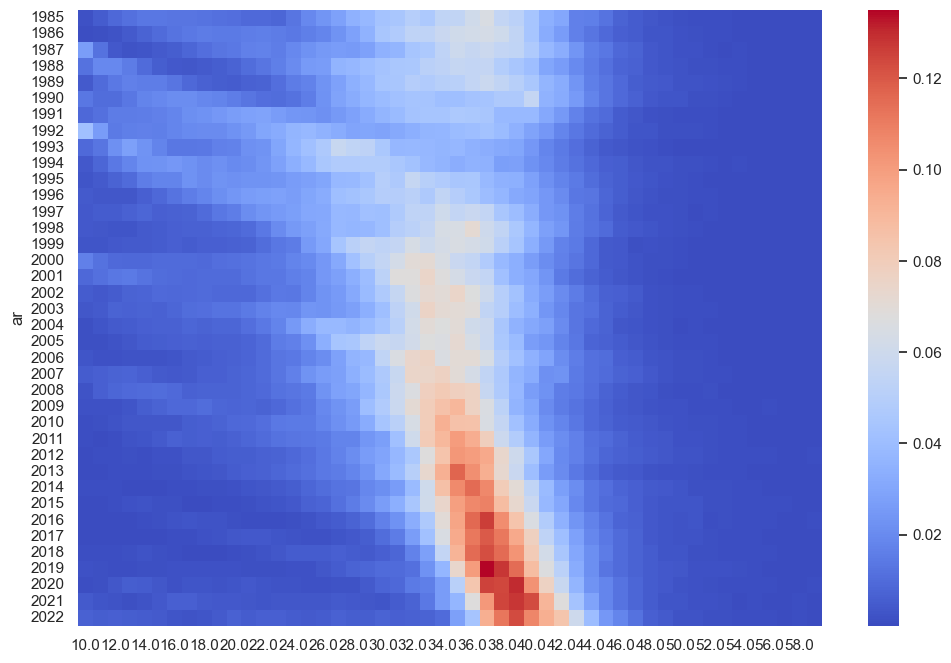

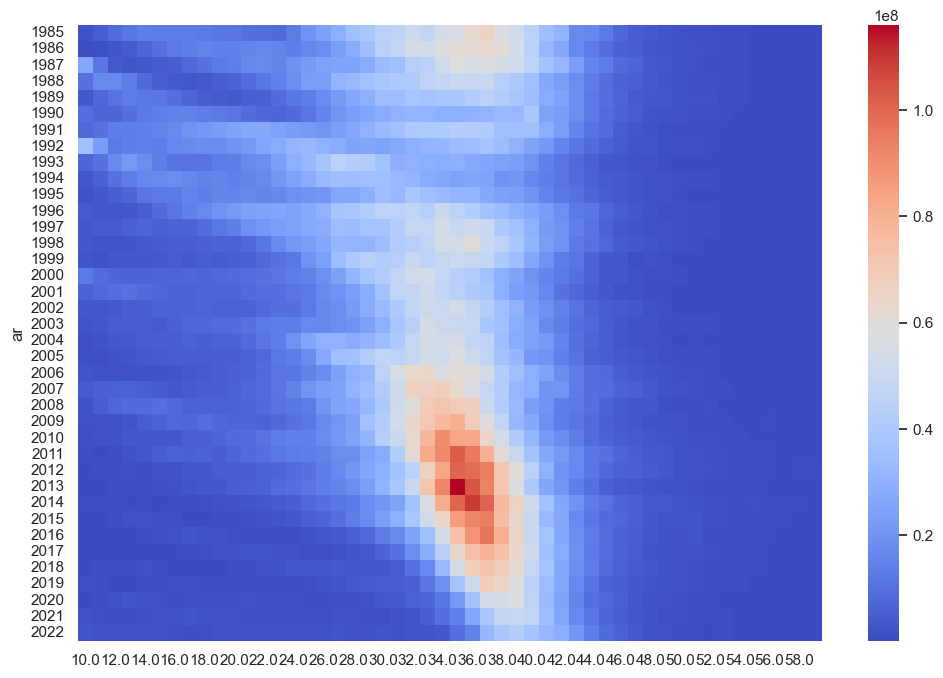

In [ ]:
fractile = '096'
interval_int = 1000000

(X, y) = get_new_data(fractile)
heat_maps(X,y)
result_dict_gb = regression_over_possible_values_XGB(X,
                                                     y,
                                                     interval_int)
plot_result_range(result_dict_gb, interval_int, fractile)


(X, y) = get_new_data(fractile)
y = pd.Series(free_regression_XGB(X, y))
heat_maps(X,y)

result_dict_gb = regression_over_possible_values_XGB(X,
                                                     y,
                                                     interval_int)
plot_result_range(result_dict_gb, interval_int, fractile)


### Appendix 1: Adjusting for large schools

The figure below shows the age distribution without correcting for large schools.

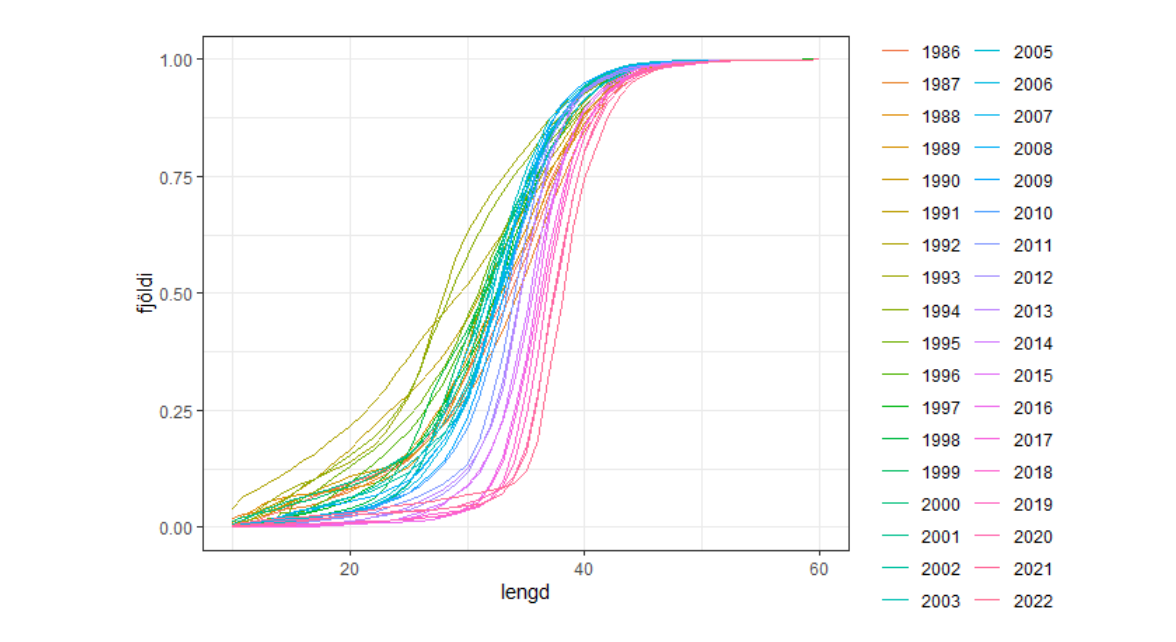

The figure below shows the age distribution where 96% fractile correction has been employed. A number of diffrerent fractile levels were tested. 

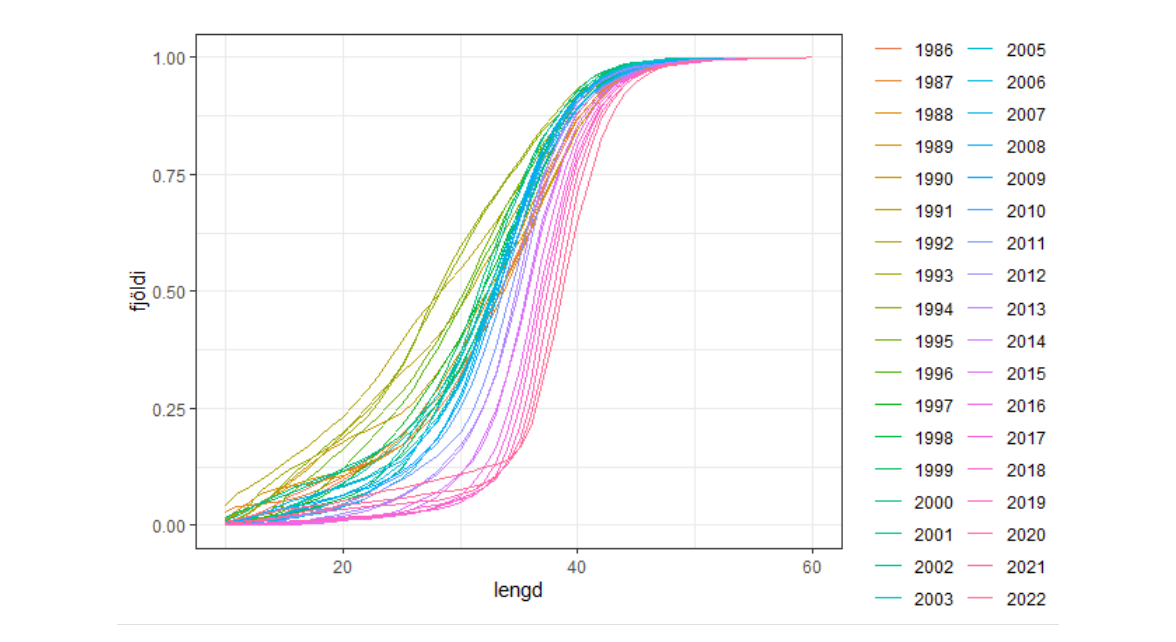

### Appendix 2 PCA analysis and colinearity

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_sca = scaler.fit_transform(X)
pca = PCA(n_components=18)
pca.fit(X_sca)
print((pca.explained_variance_ratio_))
print(pca.singular_values_)

[0.37252482 0.18312945 0.10790228 0.07008103 0.0322909  0.03053501
 0.0201818  0.01927025 0.01715119 0.01578917 0.01312605 0.01209694
 0.01115155 0.01080454 0.01029863 0.00990033 0.0086978  0.00819657]
[39.63974906 27.79280551 21.33381818 17.19307376 11.67060405 11.34886226
  9.22641936  9.01564898  8.50551137  8.16080326  7.4408113   7.14317032
  6.85837074  6.75081961  6.59087516  6.46216767  6.05700437  5.87989227]


The above tables illustrate that by decomposing the dependence matrix and ordering the eigenvectors by eigenvalues that almost 40% of the variability is connected to one eigenvector and that 70% of the variability can be reduced to three eigenvectors. Given that the number of dependant variables is 103 it is clear that there is a high degree of colinearity and that the SHAP analysis should be taken with a spoon of salt :) The next steps in the development is to try and reduce the number of variables.